# Cargamos Datos

In [1]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
path = '/shared/pytorch-CycleGAN-and-pix2pix/results_TFG/CanRuti_Clinic_NoNormal/CanRuti_Clinic_NoNormal/test_15/images'


In [3]:
variant = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE')
atypical = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE')
blast = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/BLAST')

In [4]:
def catcher(x): return re.findall('([a-zA-Z]+_+[\d]+)', x)[0]


In [5]:
variant_png = [catcher(i)+'_fake_B.png' for i in variant]
atypical_png = [catcher(i)+'_fake_B.png' for i in atypical]
blast_png = [catcher(i)+'_fake_B.png' for i in blast]

In [6]:
#for i in variant_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/VARIANT_LYMPHOCYTE", i))
#    
#for i in blast_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/BLAST", i))
#    
#for i in atypical_png:
#    copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/ATYPICAL_LYMPHOCYTE", i))
#    

In [7]:
folder_1 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

ATYPICAL_LYMPHOCYTE  VARIANT_LYMPHOCYTE  BLAST
N                   47                  57     80

In [8]:
folder_classes = "/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)


#### Creación del DataBunch de las imágenes de Can Ruti Fake

Aunque haya una separación del 50 por ciento en cada set, solo se utilizará un conjunto de validación para el test, el de training se ignorará

In [9]:
df_train = pd.read_csv('/shared/can_ruti/train.csv')
df_train['x'] = df_train['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_train['z'] = False
df_train.head()

x      y      z
0  BLAST/BL_10600573_fake_B.png  BLAST  False
1  BLAST/BL_13076127_fake_B.png  BLAST  False
2  BLAST/BL_12630836_fake_B.png  BLAST  False
3  BLAST/BL_10600634_fake_B.png  BLAST  False
4  BLAST/BL_12630955_fake_B.png  BLAST  False

In [10]:
df_valid = pd.read_csv('/shared/can_ruti/validation.csv')
df_valid['x'] = df_valid['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_valid['z'] = True
df_valid.head()

x                    y     z
0  ATYPICAL_LYMPHOCYTE/LY_13166703_fake_B.png  ATYPICAL_LYMPHOCYTE  True
1  ATYPICAL_LYMPHOCYTE/LY_13103960_fake_B.png  ATYPICAL_LYMPHOCYTE  True
2                BLAST/BL_10600656_fake_B.png                BLAST  True
3   VARIANT_LYMPHOCYTE/LY_13130834_fake_B.png   VARIANT_LYMPHOCYTE  True
4                BLAST/BL_10600719_fake_B.png                BLAST  True

In [11]:
df_split = pd.concat([df_train, df_valid])
df_split = df_split.rename(columns={'x': 'name','y': 'label','z':'is_valid'})
df_split.head()

name  label  is_valid
0  BLAST/BL_10600573_fake_B.png  BLAST     False
1  BLAST/BL_13076127_fake_B.png  BLAST     False
2  BLAST/BL_12630836_fake_B.png  BLAST     False
3  BLAST/BL_10600634_fake_B.png  BLAST     False
4  BLAST/BL_12630955_fake_B.png  BLAST     False

In [12]:
folder_classes

'/shared/Datasets_Classification/CanRuti_Fake_Cyc_Epoch_10'

In [13]:
data = (ImageList.from_df(df_split, folder_classes) #Where to find the data? -> in path and its subfolders
        .split_from_df()         #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch(num_workers=0)
        .normalize(imagenet_stats))   

In [14]:
data.batch_size = 20

#### Descripción del Conjunto de datos Can Ruti Fake

In [15]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

N
Number of classes   3
train_size         92
valid_size         92

#### Conteo de clases del conjunto de training de datos Can Ruti Fake

train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

#### Conteo de clases del conjunto de validación de datos Can Ruti Fake

valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

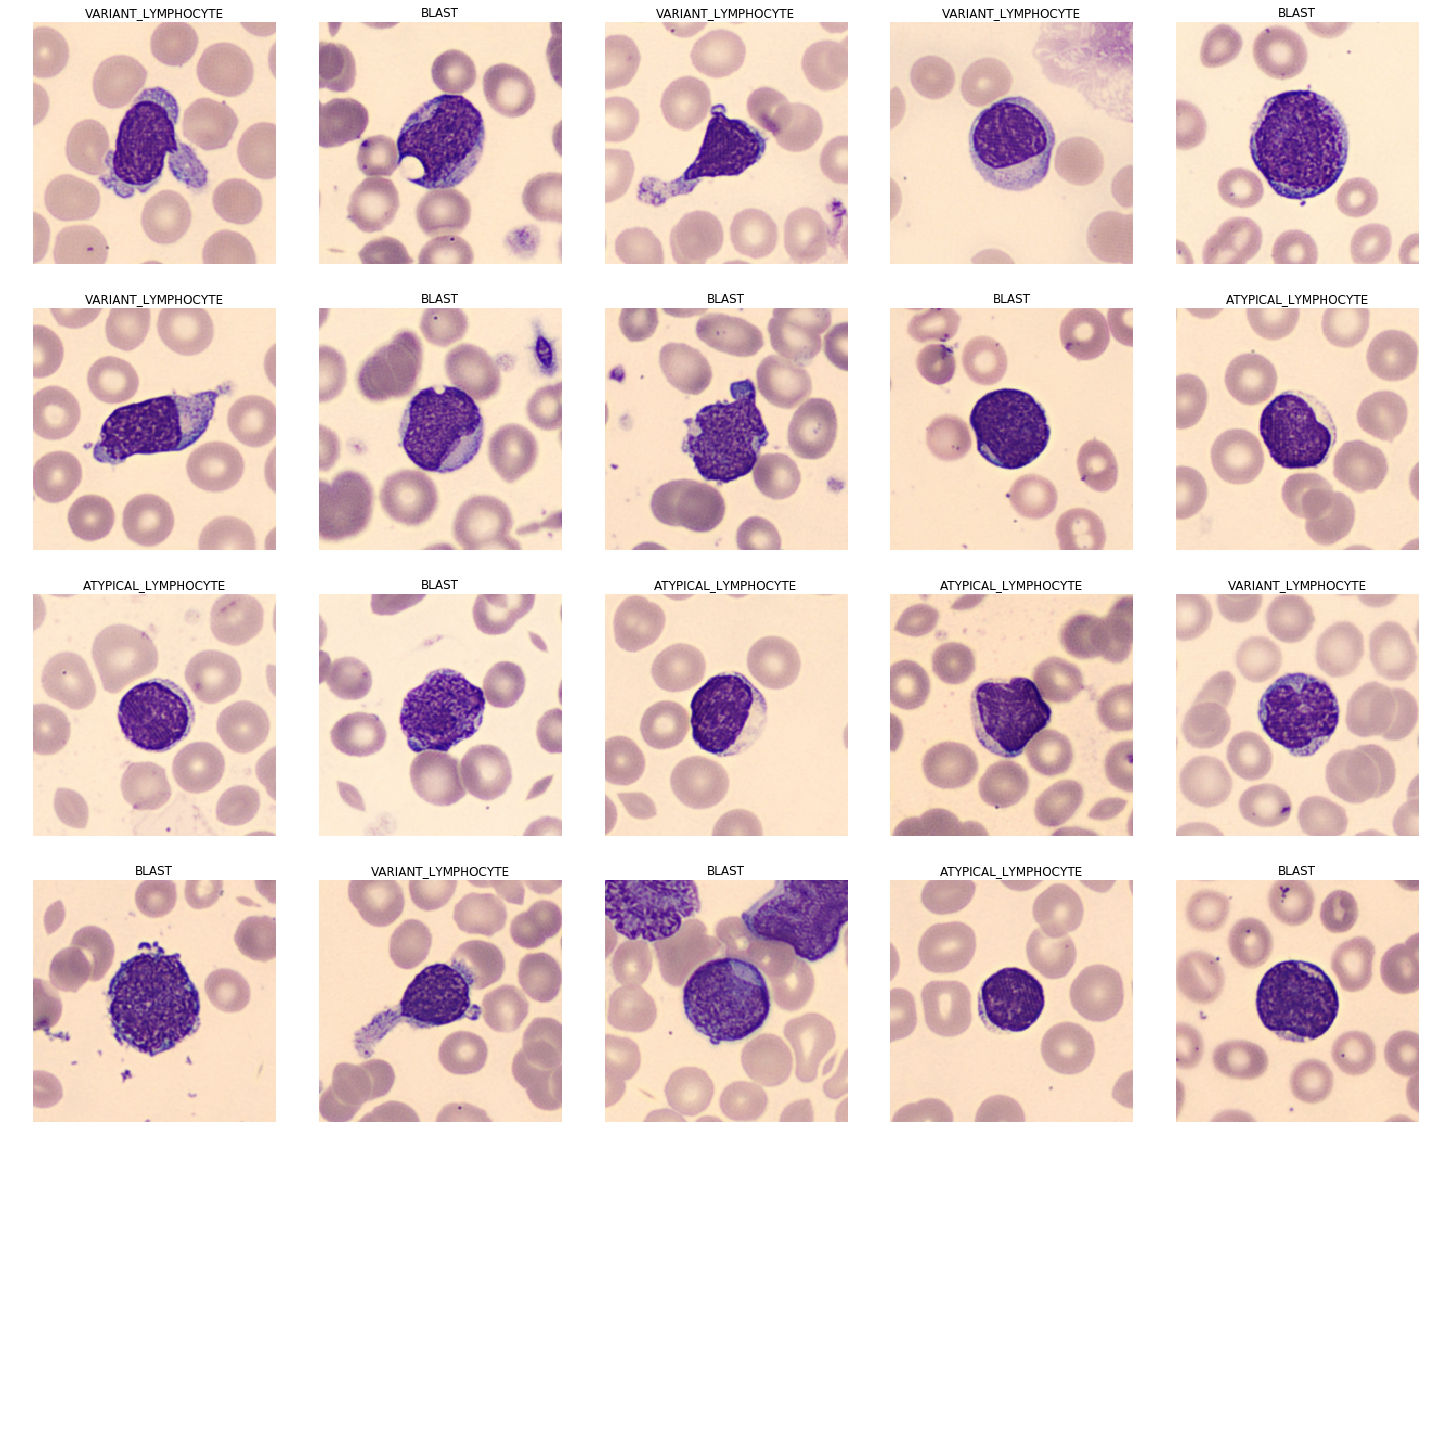

In [16]:
data.show_batch()


# Test Canruti Resnet 34 Fake Preentrenada en Clinic

In [16]:
folder_models = "/shared/Datasets_Classification/Classification_Clinic_Balanced"

Los pasos realizados con la Resnet 34 serán análogos a los de la Resnet 18

In [17]:
learn = None
learn = load_learner(folder_models, 'export_stage-2-34-Clinic_Balanced_3_Classes')
learn.data = data



In [18]:
results = learn.validate(data.valid_dl)

valid_CanRuti = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [results[0], results[1].item(),results[2].item()]) )

pd.DataFrame(valid_CanRuti, index = ['metrics'])

valid_loss  error_rate  accuracy
metrics    1.574507    0.445652  0.554348

In [20]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score # Importamos librerías necesarias
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer() # Se binarizan las etiquetas de clase de las predichas y las reales
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average) # Se calcula la roc_auc_score una vez binarizado

val_preds,val_targets = learn.get_preds() 
# obtención de las etiquetas predecidas y reales
y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
# sustitución de las etiquetas numéricas por las clases en formato string (predichas)
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes))) 
# sustitución de las etiquetas numéricas por las clases en formato string (Reales)

precision = precision_score(y_test, y_true, average='micro') # obtención de la métrica de precisión 
recall = recall_score(y_test, y_true, average='micro') # obtención de la métrica de recall
roc_auc_score = multiclass_roc_auc_score(y_test, y_true) # se obtiene la métrica de área bajo la curva ROC

# se monta el Dataframe
pd.DataFrame({'multiclass_roc_auc_score': roc_auc_score,
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

multiclass_roc_auc_score  precision    recall
metrics                  0.665761   0.554348  0.554348

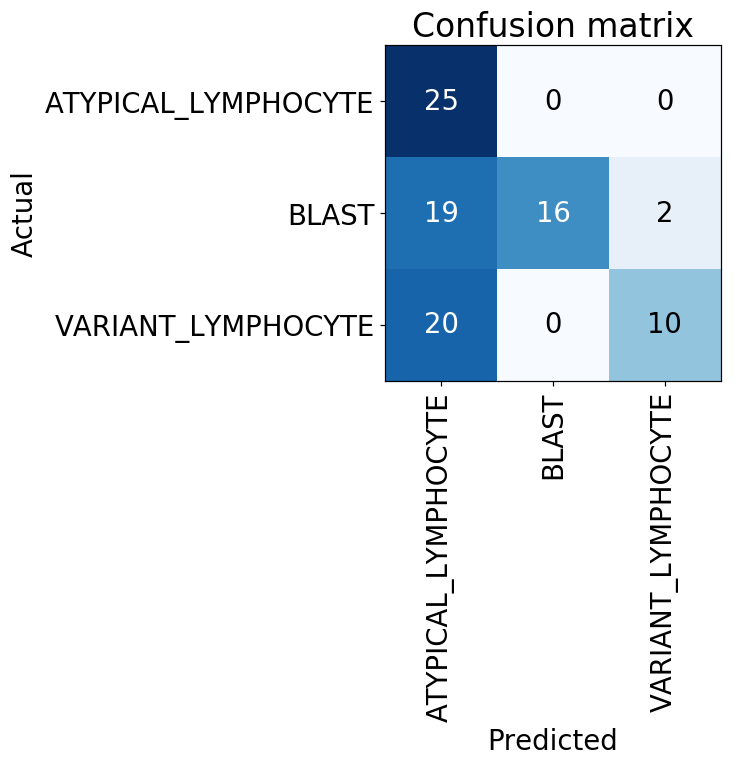

In [21]:
plt.rcParams.update({'font.size': 18})
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

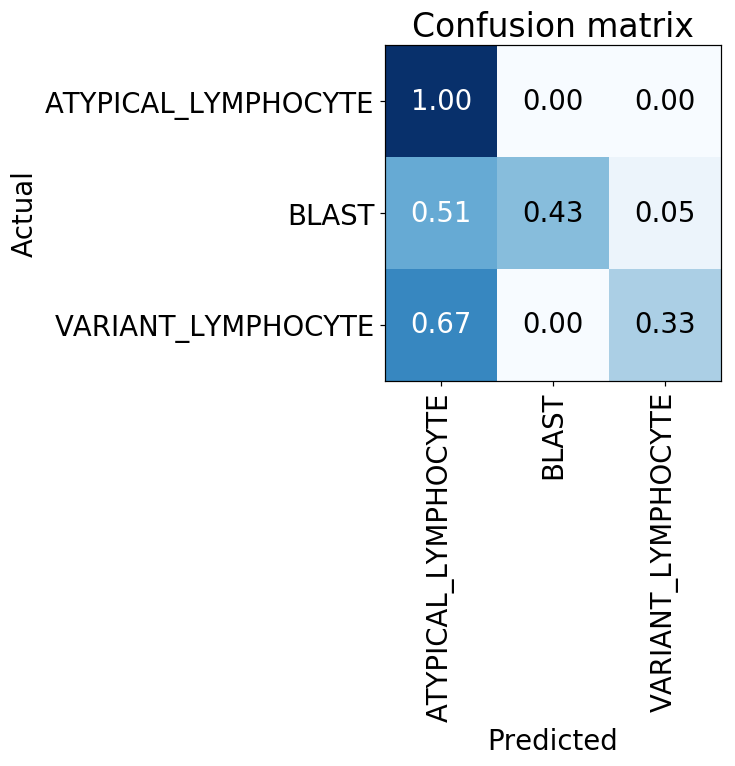

In [22]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [23]:
len(data.valid_ds)==len(losses)==len(idxs)

True

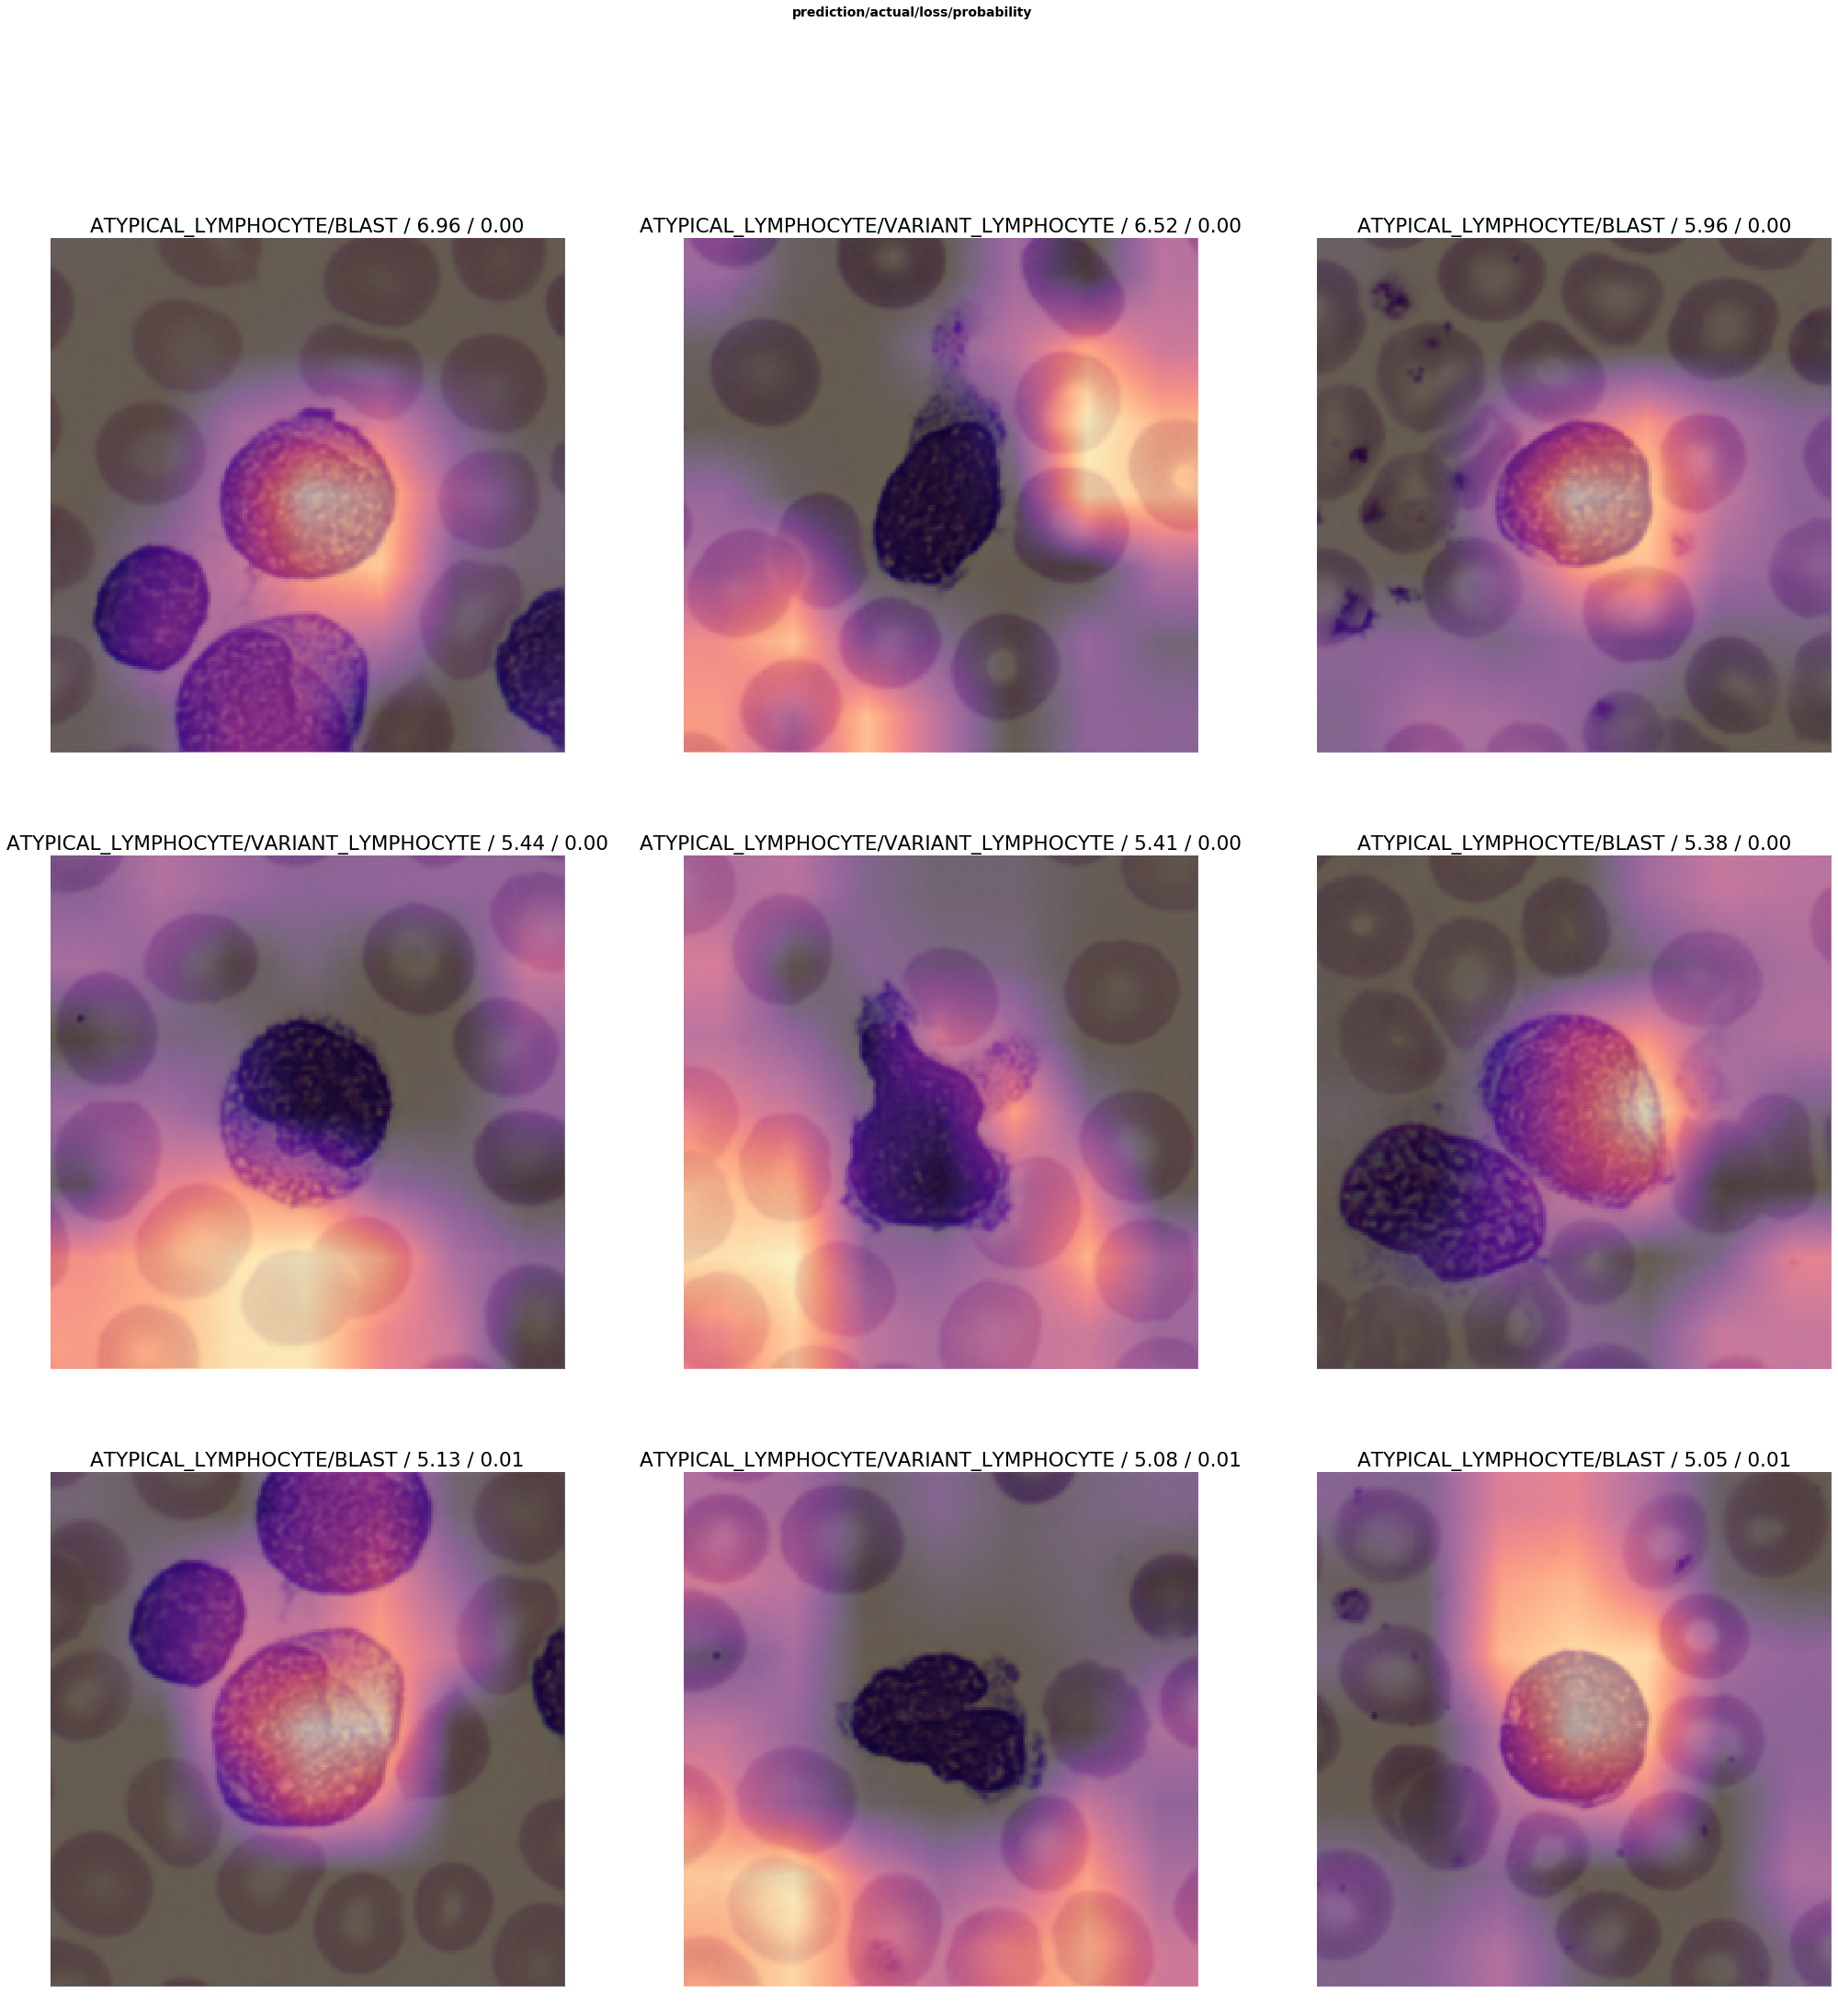

In [23]:
interp.plot_top_losses(9, figsize=(35, 35))

In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr = 3e-4)

In [25]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [26]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [27]:
learn.fit_one_cycle(3, max_lr = 3e-4)

In [28]:
learn.fit_one_cycle(3, max_lr = slice(3e-5))

In [29]:
plt.rcParams.update({'font.size': 18})

val_preds,val_targets = learn.get_preds() 
y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))
pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true)}, index = ['metrics'])

multiclass_roc_auc_score
metrics                  0.975543

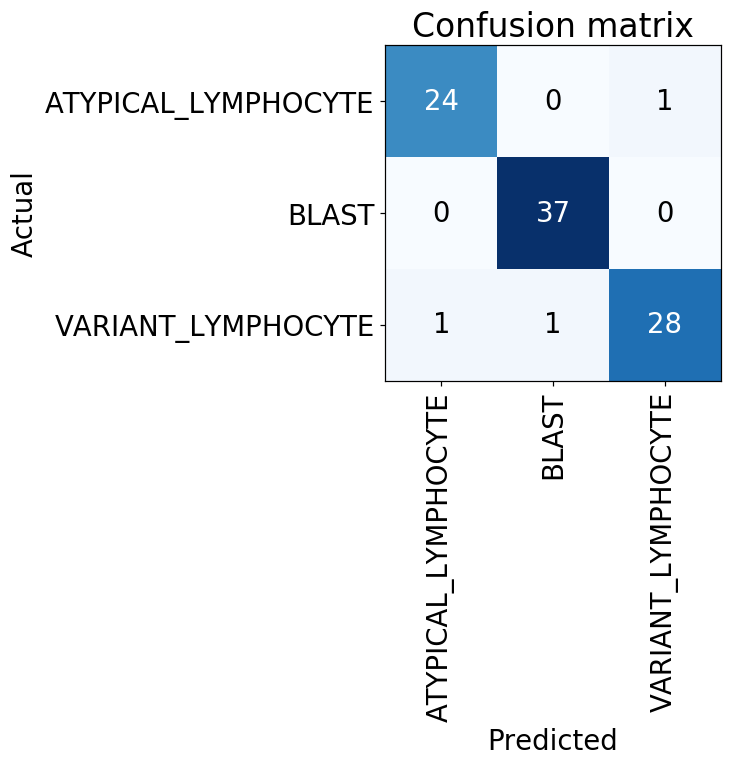

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, norm_dec=2 )

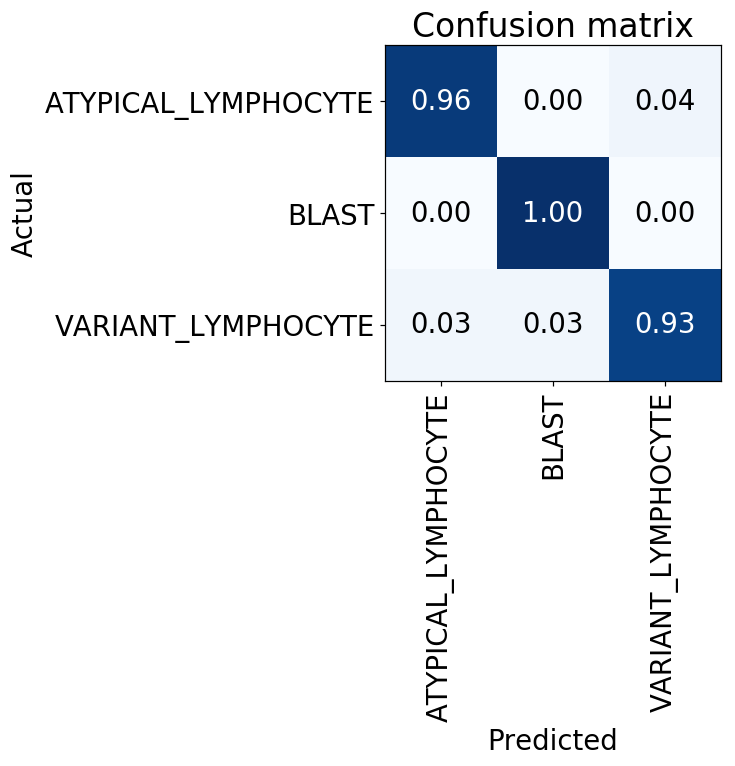

In [31]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

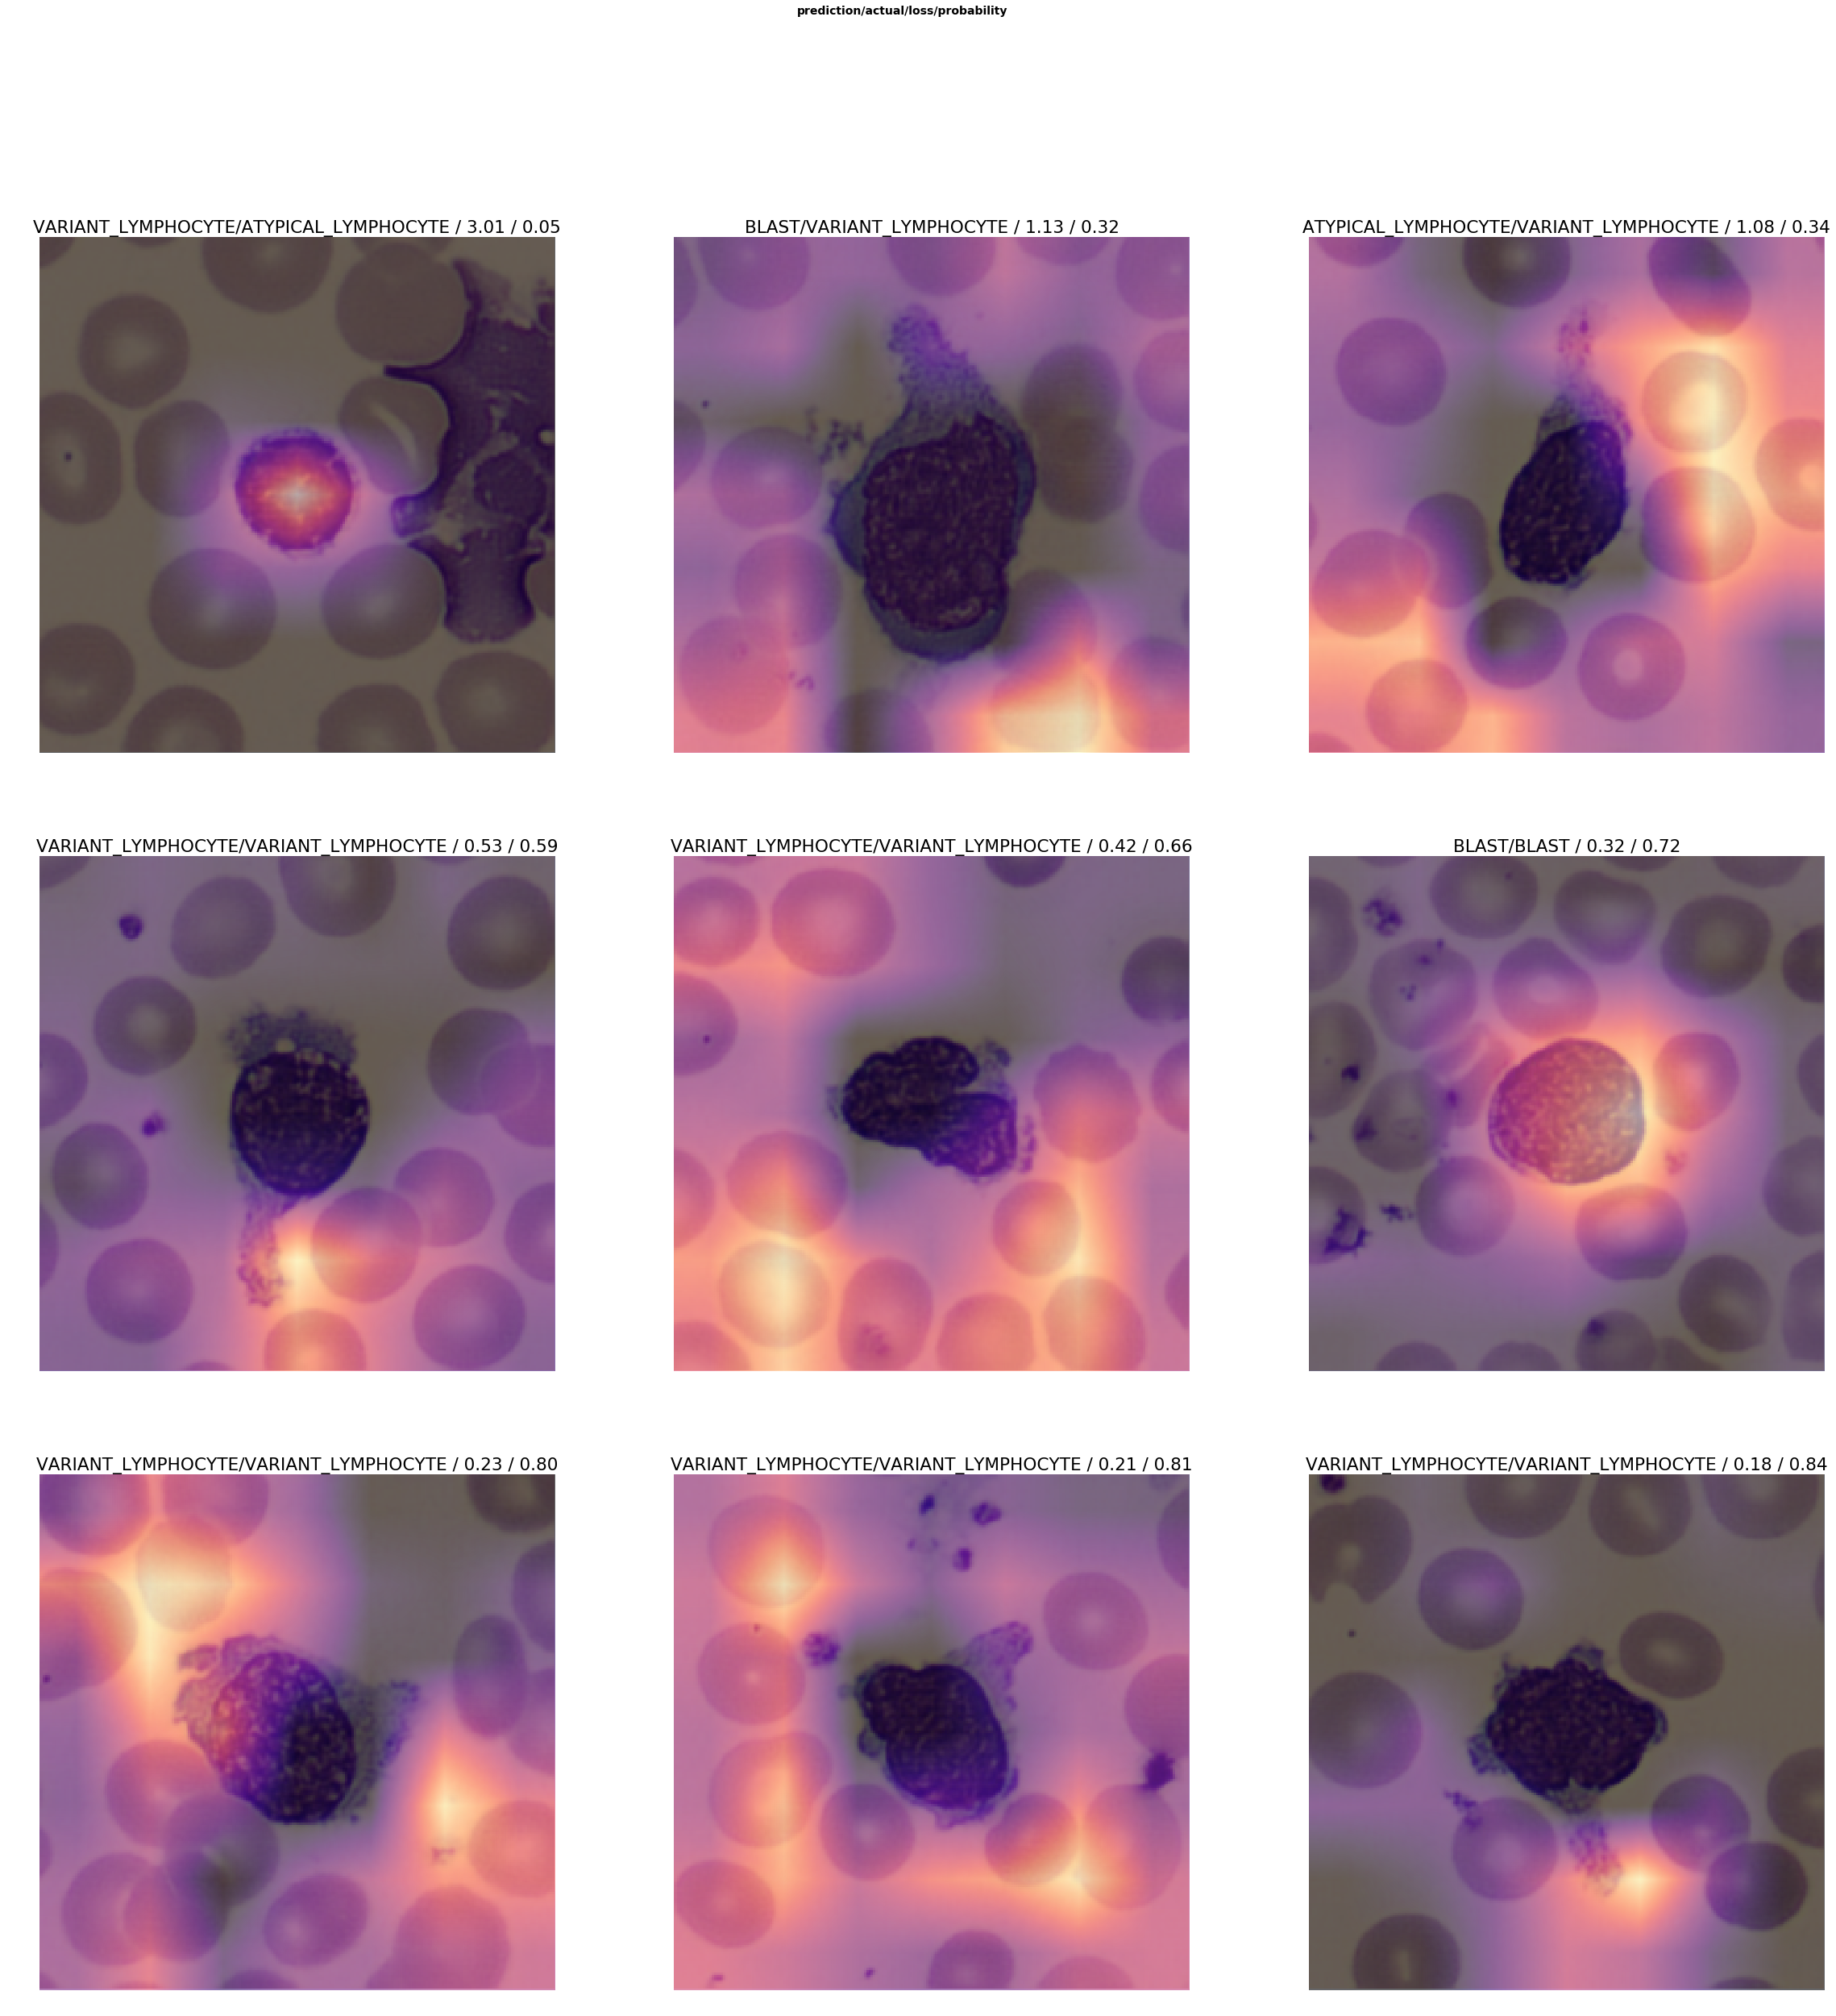

In [32]:
interp.plot_top_losses(9, largest=True, figsize=(40,40), heatmap=True)
